In [1]:
import os
import csv

from PIL import Image, ImageOps
import random

import torch
from torchvision import transforms
import torchvision.transforms.functional as TF
import numpy as np

from scipy.ndimage import gaussian_filter

# search through folders

In [2]:
def ls(directory_path, list_type = True, limit = 0, search_str=""):
    num = 0
    try:
        with os.scandir(directory_path) as entries:
            for entry in entries:
                if limit > 0 and num >= limit:
                    break
                if len(search_str) == 0 or search_str.lower() in entry.name.lower():
                    entry_type = "Folder" if entry.is_dir() else "File"
                    if(list_type):
                        print(f"{entry.name} - {entry_type}")
                    else: print(f"{entry.name}")
                    num +=1
    except FileNotFoundError:
        print("The specified directory does not exist. Please check the path.")

In [3]:
ls('../clamm', False)

2017_training
2016_task1
2016_training
2017_task1_task3
2017_task2_task4
2017_outputs
2016_task2
2016_outputs


In [4]:
ls('../clamm/2016_training/CLaMM_Training_Data_Set', limit=5)

IRHT_P_005971.tif - File
IRHT_P_008845.tif - File
IRHT_P_006304.tif - File
IRHT_P_004986.tif - File
IRHT_P_007003.tif - File


In [5]:
ls('../clamm/2016_training/CLaMM_Training_Data_Set', search_str=".csv")

@CLaMM-filelist.csv - File


# build dataset

In [2]:
# https://clamm.irht.cnrs.fr/icdar-2017/data-set/

script_conversion = {
    '1':"Caroline",
    '2':"Cursiva",
    '3':"Half Uncial",
    '4':"Humanistic",
    '5':"Humanistic Cursive",
    '6':"Hybrida",
    '7':"Praegothica",
    '8':"Semihybrida",
    '9':"Semitextualis",
    '10':"Southern Textualis",
    '11':"Textualis",
    '12':"Uncial"
}

reverse_script_conversion = {v: int(k) for k, v in script_conversion.items()}

def convert_to_script(label_number):
    """
    Convert a label number (e.g., '11') to its script name.
    """
    return script_conversion.get(str(label_number), "Unknown")

def clean_label(label):
    # Replace '_' with ' ', convert to title case, and strip spaces
    return label.replace("_", " ").title().strip()

def convert_to_number(script_name):
    """
    Convert a script name (e.g., 'Textualis') to its corresponding number.
    """
    cleaned_script_name = clean_label(script_name)
    return reverse_script_conversion.get(cleaned_script_name, -1)

def build_dataset(csv_path, image_folder, icdar = 0):


        # Routine cleaning function

    
    # Step 1: Read the CSV and store labels in a dictionary
    label_dict = {}
    with open(csv_path, mode='r') as csvfile:
        reader = csv.reader(csvfile, delimiter=';')
        # Assuming the first row is header, skip it if needed
        next(reader)
        for row in reader:
            filename = row[0+icdar]  # Adjust index based on your CSV structure
            label = row[1+icdar]  # Adjust index based on your CSV structure
            label = str(label)
            label = clean_label(script_conversion.get(label, label))
            if (label in script_conversion):
                label = script_conversion[label]
            label_dict[filename] = label

    # Step 2: Match images to labels and store the full path
    dataset = {}
    with os.scandir(image_folder) as entries:
        for entry in entries:
            if entry.is_file():
                image_id = entry.name
                
                if image_id in label_dict:  # Only add if we have a matching label
                    dataset[image_id] = {
                        'filepath': os.path.join(image_folder, entry.name),
                        'label': label_dict[image_id],
                        'label_num': reverse_script_conversion[label_dict[image_id]]
                    }

    print(f"Dataset created with {len(dataset)} items.")
    return dataset

In [4]:
string = '../clamm/2017_task2_task4'

ls(string, limit=5, search_str = ".jpg")
print()
ls(string, search_str=".csv")
print()



# Output
print(f"folder = '{string}'")
print("csvFile = '", end="")
ls(string, search_str=".csv")

CMDF_1_140b.jpg - File
710766101_MS0009_0067.jpg - File
IRHT_099740_2.jpg - File
M601415401_MS1477_0067.jpg - File
btv1b8422986v_f195.jpg - File

@ICDAR2017_CLaMM_task2_task4.csv - File

folder = '../clamm/2017_task2_task4'
csvFile = '@ICDAR2017_CLaMM_task2_task4.csv - File


In [7]:
convert_to_script(5)

'Humanistic Cursive'

In [8]:
convert_to_number('Humanistic_cursive')

5

In [3]:
csvFile = '@CLaMM-filelist.csv'
folder = '../clamm/2016_training/CLaMM_Training_Data_Set'
train_2016 = build_dataset(folder + "/" + csvFile, folder)
dataset = train_2016


folder = '../clamm/2017_training/ICDAR2017_CLaMM_Training'
csvFile = '@ICDAR2017_CLaMM_Training.csv'
new_ds = build_dataset(folder + "/" + csvFile, folder)
dataset.update(new_ds)


csvFile = '@CLaMM_task1.csv'
folder = '../clamm/2016_task1/CLaMM_task1'
new_ds = build_dataset(folder + "/" + csvFile, folder)
dataset.update(new_ds)


folder = '../clamm/2016_task2/CLaMM_task2'
csvFile = '@CLaMM_task2.csv'
new_ds = build_dataset(folder + "/" + csvFile, folder)
dataset.update(new_ds)


folder = '../clamm/2017_task1_task3'
csvFile = '@ICDAR2017_CLaMM_task1_task3.csv'
new_ds = build_dataset(folder + "/" + csvFile, folder, 1)
dataset.update(new_ds)


folder = '../clamm/2017_task2_task4'
csvFile = '@ICDAR2017_CLaMM_task2_task4.csv'
new_ds = build_dataset(folder + "/" + csvFile, folder, 1)
dataset.update(new_ds)
# dataset = new_ds

print(len(dataset), 'total images')

Dataset created with 2000 items.
Dataset created with 3540 items.
Dataset created with 1000 items.
Dataset created with 2000 items.
Dataset created with 1999 items.
Dataset created with 983 items.
8001 total images


In [10]:
list(dataset.items())[0:10]

[('IRHT_P_005971.tif',
  {'filepath': '../clamm/2017_training/ICDAR2017_CLaMM_Training/IRHT_P_005971.tif',
   'label': 'Textualis',
   'label_num': 11}),
 ('IRHT_P_008845.tif',
  {'filepath': '../clamm/2017_training/ICDAR2017_CLaMM_Training/IRHT_P_008845.tif',
   'label': 'Semihybrida',
   'label_num': 8}),
 ('IRHT_P_006304.tif',
  {'filepath': '../clamm/2017_training/ICDAR2017_CLaMM_Training/IRHT_P_006304.tif',
   'label': 'Southern Textualis',
   'label_num': 10}),
 ('IRHT_P_004986.tif',
  {'filepath': '../clamm/2017_training/ICDAR2017_CLaMM_Training/IRHT_P_004986.tif',
   'label': 'Half Uncial',
   'label_num': 3}),
 ('IRHT_P_007003.tif',
  {'filepath': '../clamm/2017_training/ICDAR2017_CLaMM_Training/IRHT_P_007003.tif',
   'label': 'Semitextualis',
   'label_num': 9}),
 ('IRHT_P_000005.tif',
  {'filepath': '../clamm/2017_training/ICDAR2017_CLaMM_Training/IRHT_P_000005.tif',
   'label': 'Textualis',
   'label_num': 11}),
 ('IRHT_P_006519.tif',
  {'filepath': '../clamm/2017_training/

In [11]:
unique_labels = set()

for _, data in dataset.items():
    label = data['label']
    unique_labels.add(label)

distinct_labels = sorted(unique_labels)
print(distinct_labels)

['Caroline', 'Cursiva', 'Half Uncial', 'Humanistic', 'Humanistic Cursive', 'Hybrida', 'Praegothica', 'Semihybrida', 'Semitextualis', 'Southern Textualis', 'Textualis', 'Uncial']


In [12]:
print(train_2016['IRHT_P_005971.tif']['filepath'])
print(train_2016['IRHT_P_005971.tif']['label'])

../clamm/2017_training/ICDAR2017_CLaMM_Training/IRHT_P_005971.tif
Textualis


### To do / discuss  
train without data augmentation for comparison

Adversarial training?
crop random size from 150-300
* resize that crop to 150
* skew random / norm dist
* Image greyscale normalization
    * grey ink: IRHT_P_002510.tif
    * bleed ink: IRHT_P_003916.tif
* denoise?
* add noise?
* compartmentalize each step as function, which can then be put into pipeline
* https://huggingface.co/docs/transformers/en/model_doc/convnext#transformers.ConvNextImageProcessor.preprocess

### Models  
* basic CNN
* https://vuminhtue.github.io/SMU_SuperPOD_101/12-Pipeline%20with%20pretrained%20Hugging%20Face/index.html
* https://huggingface.co/docs/transformers/en/model_doc/convnext
* VIT

# PyTorch Transformations

In [14]:
#!pip install torch  torchvision

# Prior Attempts

In [15]:
def preprocess_image(image):
    image = TF.adjust_brightness(image, brightness_factor = 1.10)
    image = TF.adjust_contrast(image, contrast_factor = 2.2)
    image = TF.gaussian_blur(image, kernel_size = 3)
    return image

cropped_image.show()
pp_image = preprocess_image(cropped_image)
pp_image.show()

NameError: name 'cropped_image' is not defined

In [ ]:
def clahe_pillow(image, grid_size = (15,15), clip_limit = 2.0):
    """
    Apply CLAHE-like processing to a PIL.Image using PyTorch.
    
    Parameters:
        image (PIL.Image): Input grayscale image (mode='L').
        grid_size (tuple): Number of tiles (rows, cols) to divide the image into.
        clip_limit (float): Contrast clipping limit for CLAHE.
    
    Returns:
        PIL.Image: Processed image with enhanced contrast.
    """
    # Step 1: Convert PIL.Image to PyTorch tensor
    image_tensor = TF.to_tensor(image) * 255  # Scale to [0, 255]
    image_tensor = image_tensor.squeeze(0)  # Remove channel dimension for grayscale

    # Step 2: Perform adaptive histogram equalization
    # Get image dimensions
    h, w = image_tensor.shape
    tile_h = h // grid_size[0]
    tile_w = w // grid_size[1]

    # Pad image to make it divisible by grid size
    pad_h = (tile_h * grid_size[0] - h) if h % tile_h != 0 else 0
    pad_w = (tile_w * grid_size[1] - w) if w % tile_w != 0 else 0
    image_padded = TF.pad(image_tensor.unsqueeze(0), (0, pad_w, 0, pad_h), padding_mode='reflect').squeeze(0)

    # Reshape into tiles
    tiles = image_padded.unfold(0, tile_h, tile_h).unfold(1, tile_w, tile_w)
    tiles = tiles.reshape(grid_size[0] * grid_size[1], tile_h, tile_w)

    # Apply histogram equalization to each tile
    equalized_tiles = []
    for tile in tiles:
        hist = torch.histc(tile, bins=256, min=0, max=255)
        cdf = hist.cumsum(0)
        cdf = torch.clamp(cdf - cdf.min(), min=0)
        cdf = (cdf / cdf.max()) * 255  # Normalize to [0, 255]
        tile_eq = torch.take(cdf, tile.long().view(-1)).view(tile.size())
        equalized_tiles.append(tile_eq)

    # Recombine tiles into an image
    equalized_tiles = torch.stack(equalized_tiles).view(grid_size[0], grid_size[1], tile_h, tile_w)
    processed_image = equalized_tiles.permute(0, 2, 1, 3).reshape(grid_size[0] * tile_h, grid_size[1] * tile_w)

    # Crop to original size and normalize pixel values
    processed_image = processed_image[:h, :w]

    # Step 3: Convert back to PIL.Image
    processed_pil = TF.to_pil_image(processed_image.byte())
    return processed_pil

    

In [ ]:
def bright_cont(image, clip_limit=2.0):
    """
    Adjust the brightness and contrast of a small grayscale image globally.
    
    Parameters:
        image (PIL.Image): Input grayscale image (mode='L').
        clip_limit (float): Clipping limit for histogram equalization (set > 0 for CLAHE-like clipping).
    
    Returns:
        PIL.Image: Processed image with adjusted brightness and contrast.
    """
    # Convert PIL.Image to PyTorch tensor
    image_tensor = TF.to_tensor(image) * 255  # Scale to [0, 255]
    image_tensor = image_tensor.squeeze(0)  # Remove channel dimension for grayscale

    # Calculate the histogram and cumulative distribution function (CDF)
    hist = torch.histc(image_tensor, bins=256, min=0, max=255)
    cdf = hist.cumsum(0)

    # Normalize CDF to [0, 255]
    cdf_min = cdf[cdf > 0].min()  # Avoid using the zero values
    cdf_normalized = (cdf - cdf_min) / (cdf.max() - cdf_min) * 255

    # Apply clipping to mimic CLAHE-like behavior
    if clip_limit > 0:
        cdf_normalized = torch.clamp(cdf_normalized, max=clip_limit * (255 / cdf.size(0)))

    # Map the original pixel values to adjusted values
    adjusted_tensor = torch.take(cdf_normalized, image_tensor.long())

    # Convert back to PIL.Image
    adjusted_image = TF.to_pil_image(adjusted_tensor.byte())
    return adjusted_image

In [ ]:
cropped_image.show()
pp_image = clahe_pillow(cropped_image)
pp_image_2 = bright_cont(cropped_image)
pp_image.show()
pp_image_2.show()

# Current Attempt

In [13]:
rot = transforms.RandomRotation(degrees=15)
PT_image = rot(PIL_image)


PT_image.show()

NameError: name 'PIL_image' is not defined

# Bilateral Filter

In [4]:
def blf(pil_image, sigma_color=75, sigma_space=15):
    """
    Bilateral filter implementation.
    Args:
        image (ndarray): Input image as a NumPy array (H, W, C).
        sigma_color (float): Standard deviation for color difference.
        sigma_space (float): Standard deviation for spatial distance.
    Returns:
        ndarray: Denoised image.
    """
    # Ensure image is in float format for computation
    image = np.array(pil_image).astype(np.float32)

    # Spatial Gaussian kernel
    spatial_weight = gaussian_filter(np.ones_like(image), sigma=sigma_space)

    # Output image placeholder
    output = np.zeros_like(image)

    # Iterate over each pixel
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # Define the local region (patch)
            x_min, x_max = max(i-3*sigma_space, 0), min(i+5*sigma_space+1, image.shape[0])
            y_min, y_max = max(j-3*sigma_space, 0), min(j+5*sigma_space+1, image.shape[1])

            # Extract the local patch
            patch = image[x_min:x_max, y_min:y_max]

            # Compute color difference
            color_diff = patch - image[i, j]

            # Compute color weights
            color_weight = np.exp(-(color_diff ** 2) / (2 * sigma_color ** 2))

            # Combine spatial and color weights
            weights = color_weight * spatial_weight[x_min:x_max, y_min:y_max]

            # Normalize weights
            weights /= np.sum(weights)

            # Compute the output pixel value
            output[i, j] = np.sum(weights * patch)

    return Image.fromarray(np.clip(output, 0, 255).astype(np.uint8))

# Noise generator

In [5]:
class AddGaussianNoise:
    def __init__(self, mean=0.0, std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, image):
        is_pillow = isinstance(image, Image.Image)
        if is_pillow:
            image = TF.to_tensor(image)
        noise = torch.randn_like(image) * self.std + self.mean
        noisy_image = torch.clamp(image + noise, 0, 1)
        if is_pillow:
            return TF.to_pil_image(noisy_image)
        return noisy_image


class AddSpeckleNoise:
    def __init__(self, mean=0.0, std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, image):
        is_pillow = isinstance(image, Image.Image)
        if is_pillow:
            image = TF.to_tensor(image)
        noise = torch.randn_like(image) * self.std + self.mean
        noisy_image = torch.clamp(image + image * noise, 0, 1)
        if is_pillow:
            return TF.to_pil_image(noisy_image)
        return noisy_image


class AddSaltAndPepperNoise:
    def __init__(self, amount=0.02, salt_vs_pepper=0.5):
        self.amount = amount
        self.salt_vs_pepper = salt_vs_pepper

    def __call__(self, image):
        is_pillow = isinstance(image, Image.Image)
        if is_pillow:
            image = TF.to_tensor(image)
        noisy_image = image.clone()
        num_pixels = int(self.amount * image.numel())
        salt_indices = torch.randint(0, image.numel(), (int(num_pixels * self.salt_vs_pepper),), device=image.device)
        pepper_indices = torch.randint(0, image.numel(), (int(num_pixels * (1 - self.salt_vs_pepper)),), device=image.device)
        noisy_image.view(-1)[salt_indices] = 1.0
        noisy_image.view(-1)[pepper_indices] = 0.0
        if is_pillow:
            return TF.to_pil_image(noisy_image)
        return noisy_image

# Transform pipeline

In [27]:
# https://pytorch.org/vision/main/transforms.html
# Per above URL, may want to work on converting this pipeline to v2, which uses tensors and runs faster.

from blf_torch import BilateralFilter, DEVICE

# Prepare a bilateral filter class for the pipeline.
# blf() above uses CPU and is too slow.  Below uses CUDA if available (DEVICE).
class ApplyBilateralFilter:
    def __init__(self, kernel_size=5, sigma_space=5, sigma_color=0.1):
        self.kernel_size = kernel_size
        self.sigma_space = sigma_space
        self.sigma_color = sigma_color

    def __call__(self, img):
        # Convert PIL image to tensor
        img_tensor = transforms.ToTensor()(img).unsqueeze(0).to(DEVICE)

        # Initialize the bilateral filter (dynamic size detection)
        bilateral_filter = BilateralFilter(
            channels=img_tensor.shape[1],
            k=self.kernel_size,
            height=img_tensor.shape[2],
            width=img_tensor.shape[3],
            sigma_space=self.sigma_space,
            sigma_color=self.sigma_color,
            device=DEVICE
        )

        # Apply the filter
        with torch.no_grad():
            filtered_tensor = bilateral_filter(img_tensor)

        # Convert the tensor back to a PIL image
        filtered_img = transforms.ToPILImage()(filtered_tensor.squeeze(0).to(DEVICE))
        return filtered_img
        # return filtered_tensor




# geometric transform
transform_pipeline = transforms.Compose([
    # geometric
    transforms.RandomApply(      [transforms.RandomAffine(degrees=0, shear=10, interpolation=Image.BICUBIC)              ], p=0.5)
    ,transforms.RandomApply(     [transforms.RandomRotation(degrees=15, interpolation=Image.BICUBIC)                     ], p=0.5)
    ,transforms.RandomApply(     [transforms.RandomPerspective(distortion_scale=0.2, p=0.3, interpolation=Image.BICUBIC) ], p=0.2)
    ,transforms.RandomResizedCrop(
        size=(670,670),
        scale=(0.8, 1.2),
        ratio=(0.8, 1.2),
        interpolation=Image.BICUBIC
    )
    ,ApplyBilateralFilter(kernel_size=5, sigma_space=5, sigma_color=0.1)
])

noise_pipeline = transforms.Compose([
    # color / photo effects
    transforms.RandomApply(     [transforms.GaussianBlur(kernel_size=(3,3))                                             ], p=0.2)

    ,transforms.RandomApply([transforms.RandomChoice([
                            AddGaussianNoise(mean=0.0, std=0.1),
                            AddSpeckleNoise(mean=0.0, std=0.1),
                            AddSaltAndPepperNoise(amount=0.02, salt_vs_pepper=0.5)
                        ])                                                                                               ], p = 0.25)


    
    ,transforms.CenterCrop((500,500)) # ResNet50 expects 224x224
    ,transforms.ToTensor()
    ,transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Convert 1-channel grayscale to 3-channel
    ,transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization for ResNet50
    ,transforms.ToPILImage()


])





# Ignore

In [ ]:
# I don't like the aliasing this method has.  I can't seem to change the interpolation method meaningfully.

class TensorTransformPipeline:
    def __init__(self):
        self.random_affine = transforms.RandomAffine(degrees=0, shear=10)
        self.random_rotation = transforms.RandomRotation(degrees=15)
        self.random_perspective = transforms.RandomPerspective(distortion_scale=0.2, p=0.3)
        self.random_resized_crop = transforms.RandomResizedCrop(size=(300, 300), scale=(0.8, 1.2), ratio=(0.8, 1.2))
        self.center_crop = transforms.CenterCrop(size=(150, 150))

    def __call__(self, tensor_image):
        # Apply transformations to the tensor
        tensor_image = self.random_affine(tensor_image)
        tensor_image = self.random_rotation(tensor_image)
        tensor_image = self.random_perspective(tensor_image)
        tensor_image = self.random_resized_crop(tensor_image)
        tensor_image = self.center_crop(tensor_image)
        return tensor_image


tensor_image = TF.to_tensor(PIL_image).mul(255).to(torch.uint8)
transform_pipeline = TensorTransformPipeline()
transformed_tensor = transform_pipeline(tensor_image)
transformed_pil_image = TF.to_pil_image(transformed_tensor)
transformed_pil_image.show()



In [ ]:
# don't like

transform_pipeline2 = transforms.Compose([
    # transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10 )
    # transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.IMAGENET )
    # transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.SVHN )
    transforms.RandAugment(num_ops=2, magnitude = 9)
    ,transforms.CenterCrop((150,150))

    

])



PT_image = transform_pipeline2(PIL_image)
PT_image.show()

# Resample and show all below

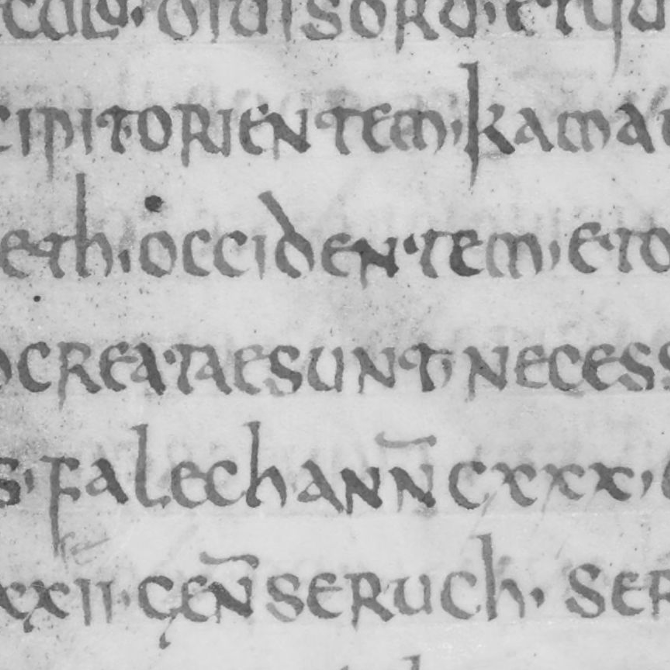

Uncial
btv1b10511002k_f33.tif


In [24]:
#imgs =     ['IRHT_P_005971.tif',    'IRHT_P_008845.tif',    'IRHT_P_006304.tif',    'IRHT_P_004986.tif',    'IRHT_P_007003.tif']

random_choice = random.choice(list(dataset.keys()))
image_path = dataset[random_choice]['filepath']
label = dataset[random_choice]['label']
image = Image.open(image_path)

def crop_sample(image):
    crop_dim = 670
    
    img_width, img_height = image.size
    
    margin_x = int(img_width * 0.05)
    margin_y = int(img_height * 0.05)
    
    max_x = img_width - crop_dim - margin_x
    max_y = img_height - crop_dim - margin_y
    
    left = random.randint(margin_x, max_x)
    upper = random.randint(margin_y, max_y)
    
    crop_box = (left, upper, left + crop_dim, upper + crop_dim)
    cropped_image = image.crop(crop_box)
    return cropped_image

cropped_image = crop_sample(image)
cropped_image.show()
print(label)
print(random_choice)

In [ ]:


# adding noise should happen AFTER the bilateral filter

print("original")
cropped_image.show()
print("grayscale")
PIL_image = cropped_image.convert("L") # luma grayscale
print("autocontrast")
PIL_image = ImageOps.autocontrast(PIL_image, cutoff=5)
PIL_image.show()

print("geometric transform pipeline")
PT_image = transform_pipeline(PIL_image)
PT_image.show()

print("bilateral filter")
# BLF_image = blf(PT_image)
# trans_tensor = transforms.ToTensor()
# img_tensor = trans_tensor(PT_image).unsqueeze(0).to(DEVICE)
# # Initialize the bilateral filter
# bilateral_filter = BilateralFilter(
#     channels=1,  # Grayscale
#     k=5,  # Kernel size
#     height=img_tensor.shape[2],
#     width=img_tensor.shape[3],
#     sigma_space=5,
#     sigma_color=0.1,
#     device=DEVICE
# )
# with torch.no_grad():
#     filtered_tensor = bilateral_filter(img_tensor)
# to_pil = transforms.ToPILImage()
# BLF_image = to_pil(filtered_tensor.squeeze(0).cpu())


# BLF_image.show()
print("autocontrast")
BLF_image = ImageOps.autocontrast(PT_image, cutoff=3)
BLF_image.show()

print("noise pipeline")
noise_image = noise_pipeline(BLF_image)
noise_image.show()

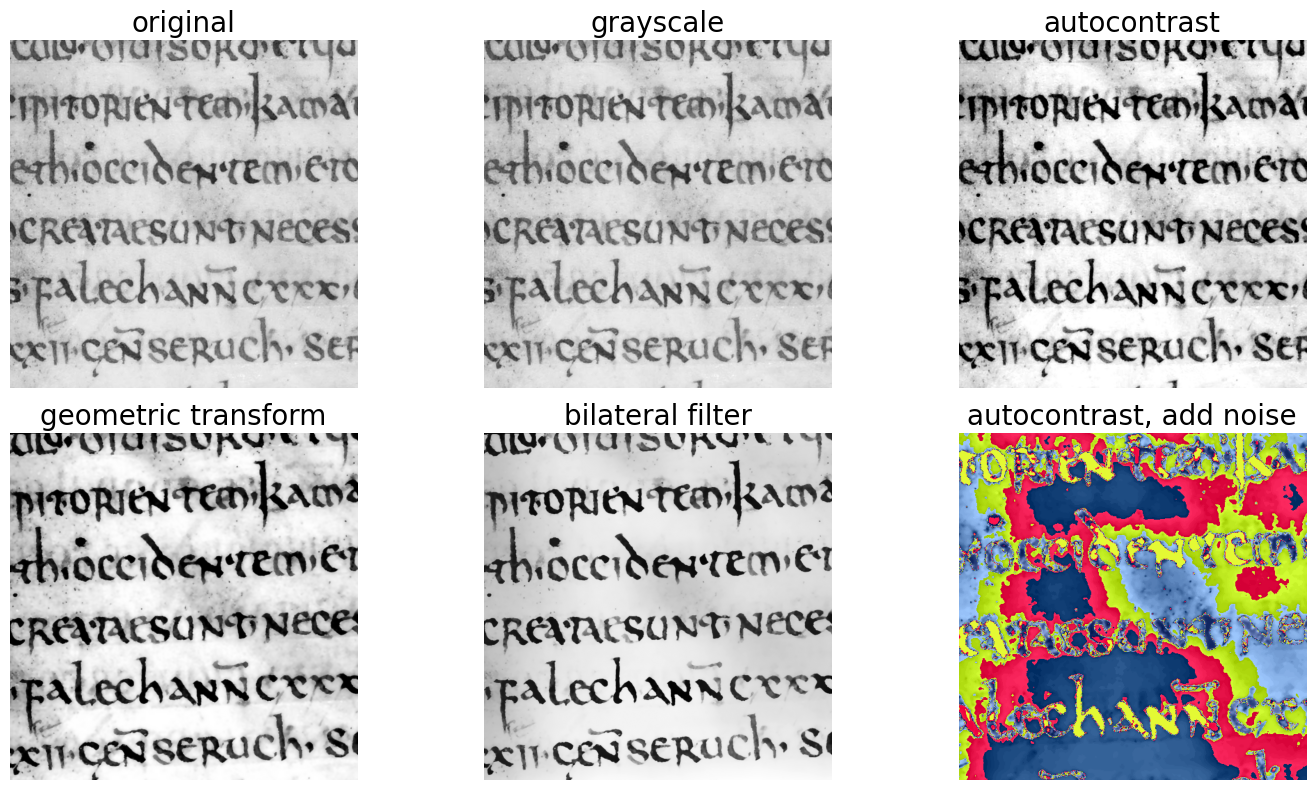

In [28]:
import matplotlib.pyplot as plt

PIL_image = cropped_image.convert("L") # luma grayscale
PIL_image_ac = ImageOps.autocontrast(PIL_image, cutoff=5)
PT_image_geo = transform_pipeline(PIL_image_ac)
blf_img = blf(PT_image_geo)
blf_ac = ImageOps.autocontrast(blf_img, cutoff=3)
noise_img = noise_pipeline(blf_ac)

steps = [
    ("original", cropped_image),
    ("grayscale", PIL_image),
    ("autocontrast", PIL_image_ac),
    ("geometric transform", PT_image_geo),
    ("bilateral filter", blf_img),
    # ("autocontrast (post bilateral)", blf_ac),
    ("autocontrast, add noise", noise_img),
]

# Plot each step in a grid
rows, cols = 2, 3  # Adjust grid size as needed
fig, axes = plt.subplots(rows, cols, figsize=(15, 8))

for i, ax in enumerate(axes.flat):
    if i < len(steps):
        label, image = steps[i]
        ax.imshow(image, cmap="gray")  # Use 'gray' for grayscale images
        ax.set_title(label, fontsize=20)
        ax.axis("off")
    else:
        ax.axis("off")  # Hide unused axes

# Adjust layout
plt.tight_layout()
plt.show()

# print(label)

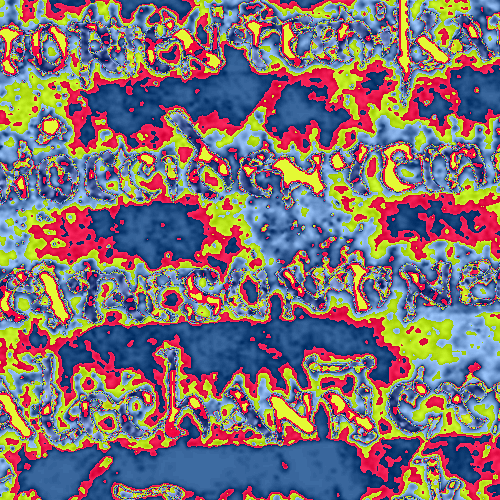

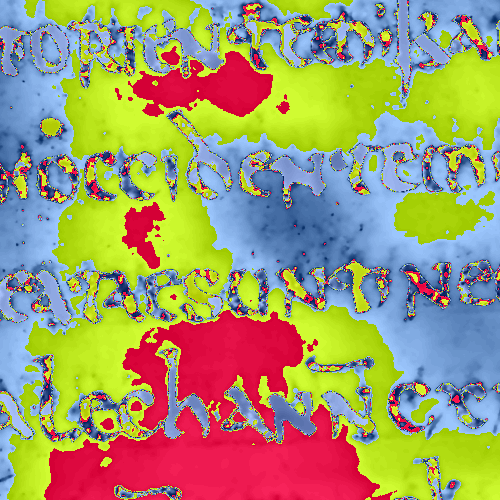

In [30]:
noise_pipeline(PT_image_geo).show()
noise_pipeline(blf_img).show()

In [ ]:
random_choice = random.choice(list(dataset.keys()))
image_path = dataset[random_choice]['filepath']
label = dataset[random_choice]['label']
image = Image.open(image_path)

cropped_image = crop_sample(image)
print("original")
cropped_image.show()
# print("grayscale")
PIL_image = cropped_image.convert("L") # luma grayscale
# print("autocontrast")
PIL_image = ImageOps.autocontrast(PIL_image, cutoff=5)
# PIL_image.show()

# print("geometric transform pipeline")
PT_image = transform_pipeline(PIL_image)
# PT_image.show()
BLF_image = ImageOps.autocontrast(PT_image, cutoff=3)
# BLF_image.show()

print("noise pipeline")
noise_image = noise_pipeline(BLF_image)
noise_image.show()

In [ ]:
# !pip install scikit_learn

In [ ]:
# manual test/train split because of above error


filenames = list(dataset.keys())
random.shuffle(filenames)

test_ratio = 0.2
split_idx = int(len(filenames) * (1-test_ratio))

train_filenames = filenames[:split_idx]
test_filenames = filenames[split_idx:]

print("train:", len(train_filenames))
print("test: ", len(test_filenames))

train_dataset = {fname: dataset[fname] for fname in train_filenames}
test_dataset = {fname: dataset[fname] for fname in test_filenames}

print("train:", len(train_dataset))
print("test: ", len(test_dataset))

def save_dataset_to_csv(dataset, csv_file):
    with open(csv_file, mode="w", newline="") as file:
        writer = csv.writer(file)

        # Write header
        writer.writerow(["filename", "filepath", "label", "label_num"])

        # Write dataset entries
        for filename, data in dataset.items():
            writer.writerow([filename, data['filepath'], data['label'], data['label_num']])

# Save train and test splits to CSV
save_dataset_to_csv(train_dataset, "train_dataset.csv")
save_dataset_to_csv(test_dataset, "test_dataset.csv")

In [ ]:
import csv

with open('train_dataset.csv', mode='r', encoding='utf-8') as file:
    reader = csv.DictReader(file)  # Reads the CSV into a list of dictionaries
    data = [{**row, 'label_num': int(row['label_num'])} for row in reader]  # Convert label_num to int
# Print the dictionary
for row in data[:3]:
    print(row)

In [ ]:
from torch.utils.data import Dataset

class ScriptDataset(Dataset):
    def __init__(self, dataset, transform=None):
        """
        dataset: dict containing image paths and labels
        transform: torchvision transforms (augmentations + preprocessing)
        """
        self.dataset = list(dataset.items())  # Convert dict to list for indexing
        self.transform = transform

    def crop_sample(self, image, crop_dim=300):
        """Crop a random 300x300 region."""
        img_width, img_height = image.size
        margin_x = int(img_width * 0.05)
        margin_y = int(img_height * 0.05)
        max_x = img_width - crop_dim - margin_x
        max_y = img_height - crop_dim - margin_y

        left = random.randint(margin_x, max_x)
        upper = random.randint(margin_y, max_y)
        crop_box = (left, upper, left + crop_dim, upper + crop_dim)
        return image.crop(crop_box)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get image path and label
        img_path, label = self.dataset[idx]
        image = Image.open(img_path).convert("L")  # Convert to grayscale

        # Apply initial crop
        image = self.crop_sample(image)

        # Apply transforms (if any)
        if self.transform:
            image = self.transform(image)

        return image, label